# Make upper 50m means of bottom up drivers and phytoC pools
# in each region, for each epoch
### this part takes a lot of time and preprocessing it here will save time/space in other notebooks

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob

import xarray as xr
import numpy as np

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
import math
import cmocean

### get pop grid

In [2]:
grid = pop_tools.get_grid('POP_gx1v6')

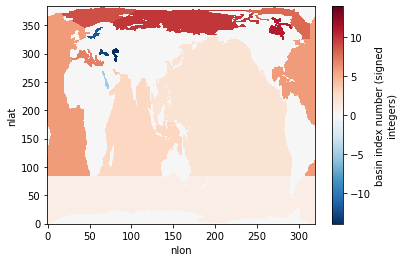

In [3]:
grid.REGION_MASK.plot()

In [4]:
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, nreg: 14, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Caspian Sea' 'Black Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -14 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v6/grid/topography_20090204.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.ieeei4
    type:               dipole
    title:              POP_gx1v6 grid

In [19]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### get masks for making averages

In [6]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1920s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

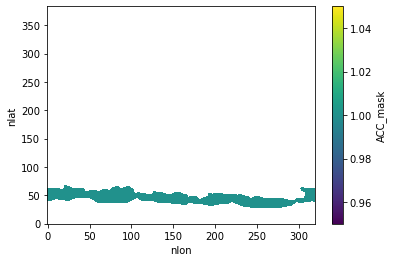

In [7]:
ds_masks.ACC_mask.plot()

## Make 100m annual means for each region

In [9]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint100m','spC_zint100m','zooC_zint100m',
             'spNPP_zint100m','diatNPP_zint100m','NPP_zint100m','zoo_prod_zint100m',
             'TEMP_100m_mean','SHF_QSW','Fe_avg_100m','phys_med_Fe','PAR_avg_100m','TEMP_surf']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

diatC_zint100m
spC_zint100m
zooC_zint100m
spNPP_zint100m
diatNPP_zint100m
NPP_zint100m
zoo_prod_zint100m
TEMP_100m_mean
SHF_QSW
Fe_avg_100m
phys_med_Fe
PAR_avg_100m
TEMP_surf
CPU times: user 1.01 s, sys: 70.7 ms, total: 1.08 s
Wall time: 3.31 s


In [10]:
ds['PAR_surf'] = ds.SHF_QSW * 0.45

In [11]:
variables = variables + ['PAR_surf']

### extract 1920s

In [12]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [13]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### Extract 2090s

In [14]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [15]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

In [16]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

In [17]:
outside=np.full((384, 320), 2)

inside = ds_masks.ACC_mask.where(ds_masks.ACC_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

ACC=xr.DataArray(outside)
ACC=ACC.rename({'dim_0':'nlat'})
ACC=ACC.rename({'dim_1':'nlon'})
ACC = ACC.where(grid.REGION_MASK>0)
#ACC.plot()

In [18]:
outside=np.full((384, 320), 2)

inside = ds_masks.SIZ_mask.where(ds_masks.SIZ_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

SIZ=xr.DataArray(outside)
SIZ=SIZ.rename({'dim_0':'nlat'})
SIZ=SIZ.rename({'dim_1':'nlon'})
SIZ = SIZ.where(grid.REGION_MASK>0)
#SIZ.plot()

In [19]:
%%time
ACC_1920s_ds = xr.Dataset()
ACC_2090s_ds = xr.Dataset()
SIZ_1920s_ds = xr.Dataset()
SIZ_2090s_ds = xr.Dataset()

for v in variables:
    print(v)

    masked = ensemble_mean_1920s[v].where(ACC==1)
    ACC_1920s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

    masked = ensemble_mean_2090s[v].where(ACC==1)
    ACC_2090s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()
    
    masked = ensemble_mean_1920s[v].where(SIZ==1)
    SIZ_1920s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

    masked = ensemble_mean_2090s[v].where(SIZ==1)
    SIZ_2090s_ds[v] = esmlab.statistics.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()
    

diatC_zint100m
spC_zint100m
zooC_zint100m
spNPP_zint100m
diatNPP_zint100m
NPP_zint100m
zoo_prod_zint100m
TEMP_100m_mean
SHF_QSW
Fe_avg_100m
phys_med_Fe
PAR_avg_100m
TEMP_surf
PAR_surf
CPU times: user 22 s, sys: 44.6 s, total: 1min 6s
Wall time: 3min 22s


In [20]:
file = '/glade/scratch/kristenk/CESM-LE-output/annual_upper_100m_means_SIZ-1920s.nc'
SIZ_1920s_ds.to_netcdf(file)

In [21]:
file = '/glade/scratch/kristenk/CESM-LE-output/annual_upper_100m_means_SIZ-2090s.nc'
SIZ_2090s_ds.to_netcdf(file)

In [22]:
file = '/glade/scratch/kristenk/CESM-LE-output/annual_upper_100m_means_ACC-1920s.nc'
ACC_1920s_ds.to_netcdf(file)

In [23]:
file = '/glade/scratch/kristenk/CESM-LE-output/annual_upper_100m_means_ACC-2090s.nc'
ACC_2090s_ds.to_netcdf(file)

In [24]:
ACC_2090s_ds

<xarray.Dataset>
Dimensions:            ()
Data variables:
    diatC_zint100m     float64 63.98
    spC_zint100m       float64 49.79
    zooC_zint100m      float64 72.22
    spNPP_zint100m     float64 0.01359
    diatNPP_zint100m   float64 0.01538
    NPP_zint100m       float64 0.02897
    zoo_prod_zint100m  float64 0.006424
    TEMP_100m_mean     float64 6.43
    SHF_QSW            float64 103.3
    Fe_avg_100m        float64 0.0001991
    phys_med_Fe        float64 3.443e-08
    PAR_avg_100m       float64 9.36
    TEMP_surf          float64 7.018
    PAR_surf           float64 46.5

In [25]:
ACC_1920s_ds

<xarray.Dataset>
Dimensions:            ()
Data variables:
    diatC_zint100m     float64 58.01
    spC_zint100m       float64 66.35
    zooC_zint100m      float64 76.65
    spNPP_zint100m     float64 0.01516
    diatNPP_zint100m   float64 0.01178
    NPP_zint100m       float64 0.02694
    zoo_prod_zint100m  float64 0.005867
    TEMP_100m_mean     float64 3.323
    SHF_QSW            float64 108.2
    Fe_avg_100m        float64 0.000183
    phys_med_Fe        float64 3.177e-08
    PAR_avg_100m       float64 9.839
    TEMP_surf          float64 3.837
    PAR_surf           float64 48.68